1. Importación de librerías.

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

2. Conexión a la base de datos.

In [3]:
load_dotenv()
my_password = os.getenv("db_password")
my_db = os.getenv("db_name")
my_user = os.getenv("db_user")

try:
    # Establecer los parámetros de conexión

    conection = psycopg2.connect(
        host="localhost",
        database=my_db,
        user=my_user,
        password=my_password,
        client_encoding="utf-8"
    )
    print("Conexión exitosa a PostgreSQL")
    # Creación del cursor mediante el cual se aplicará el código SQL

    cursor = conection.cursor()
    cursor.execute(
    """
    SELECT
    vta.numero_factura,
    vta.fecha_factura,
    pd.nombre_producto,
    fm.nombre_familia,
    vta.cantidad_factura,
    (pd.costo_producto * (1 + pd.margen_producto)) * vta.cantidad_factura  AS subtotal_factura,
    vn.nombre_vendedor
    FROM
    ventas_diarias vta
    INNER JOIN
    producto pd ON vta.codigo_producto = pd.codigo_producto
    INNER JOIN
    familia fm ON pd.codigo_familia = fm.codigo_familia
    INNER JOIN
    vendedor vn ON vta.codigo_vendedor = vn.codigo_vendedor;
    """
    )

    data_frame = pd.DataFrame(
        cursor.fetchall(),
        columns=["No. factura", "Fecha factura", "Nombre producto", "Familia", "Cantidad", "Subtotal", "Vendedor" ]
    )

except Exception as error:
    print(f"Error al conectar a PostgreSQL: {error}")
finally:
    conection.close()

data_frame

Conexión exitosa a PostgreSQL


,No. factura,Fecha factura,Nombre producto,Familia,Cantidad,Subtotal,Vendedor
0,1,2024-04-14,Falda,Ropa,17,637.5000,Ana García
1,2,2024-01-24,Libro Infantil,Libros,1,29.0000,Luis Martínez
2,3,2024-02-18,Pelota de Fútbol,Deportes,9,391.5000,Ana García
3,4,2024-01-26,Cerveza,Bebidas,5,10.8750,José Sánchez
4,5,2024-05-04,Libro de Ciencia,Libros,15,607.5000,Luis Martínez
...,...,...,...,...,...,...,...
8894,9997,2024-01-03,Sofá,Muebles,4,3120.0000,Marta Rodríguez
8895,9998,2024-05-28,Raqueta de Tenis,Deportes,8,832.0000,Ana García
8896,9999,2024-01-16,Puzzle,Juguetes,15,435.0000,Luis Martínez
8897,10000,2024-04-19,Enciclopedia,Libros,17,1547.0000,Luis Martínez


3. Identificación de valores nulos y outliers.

In [4]:
# Valores nulos

valores_nulos = data_frame.isnull().sum()
valores_nulos

No. factura        0
Fecha factura      0
Nombre producto    0
Familia            0
Cantidad           0
Subtotal           0
Vendedor           0
dtype: int64

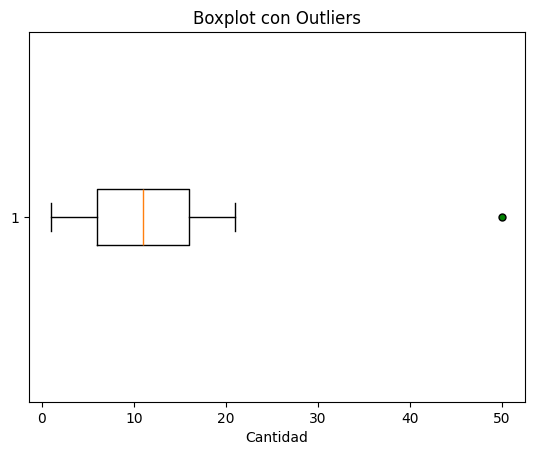

In [5]:
# Outliers

plt.boxplot(
    data_frame["Cantidad"], 
    vert=False, 
    flierprops=dict(marker="o", markerfacecolor="green", markersize=5)
)
plt.xlabel("Cantidad")
plt.title("Boxplot con Outliers")
plt.show()

4. Creación de gráficas para análisis de datos.

In [6]:
ventas_por_vendedor = data_frame.groupby("Vendedor")["Subtotal"].sum()
ventas_por_vendedor

Vendedor
Ana García         4215112.7800
Carlos Pérez       2174922.5800
José Sánchez       4247771.4000
Luis Martínez      4122241.8650
Marta Rodríguez    3953688.5800
Name: Subtotal, dtype: object

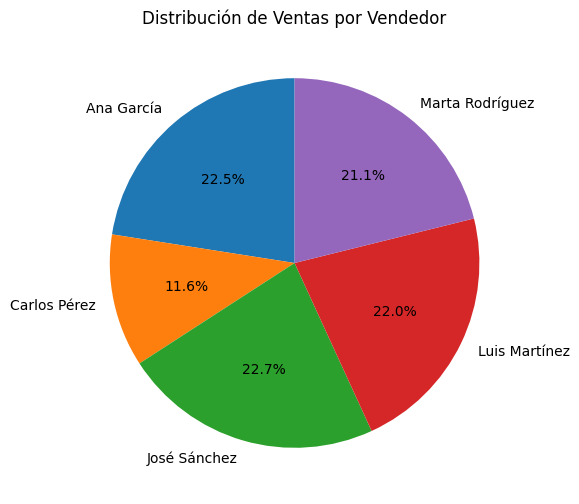

In [7]:
# Gráfico de pie 

plt.figure(figsize=(8, 6))
plt.pie(
    ventas_por_vendedor, 
    labels=ventas_por_vendedor.index, 
    autopct="%1.1f%%", startangle=90
)
plt.title("Distribución de Ventas por Vendedor")
plt.show()

In [8]:
ventas_por_familia = data_frame.groupby("Familia")["Subtotal"].sum()
ventas_por_familia = ventas_por_familia.sort_values(ascending=False)
ventas_por_familia

Familia
Tecnología           6157435.0000
Electrodomésticos    4343054.0000
Muebles              3512921.5000
Deportes             2412652.0000
Calzado               850099.5000
Ropa                  539056.5000
Libros                412644.5000
Juguetes              390764.0000
Alimentos              49156.0300
Bebidas                45954.1750
Name: Subtotal, dtype: object

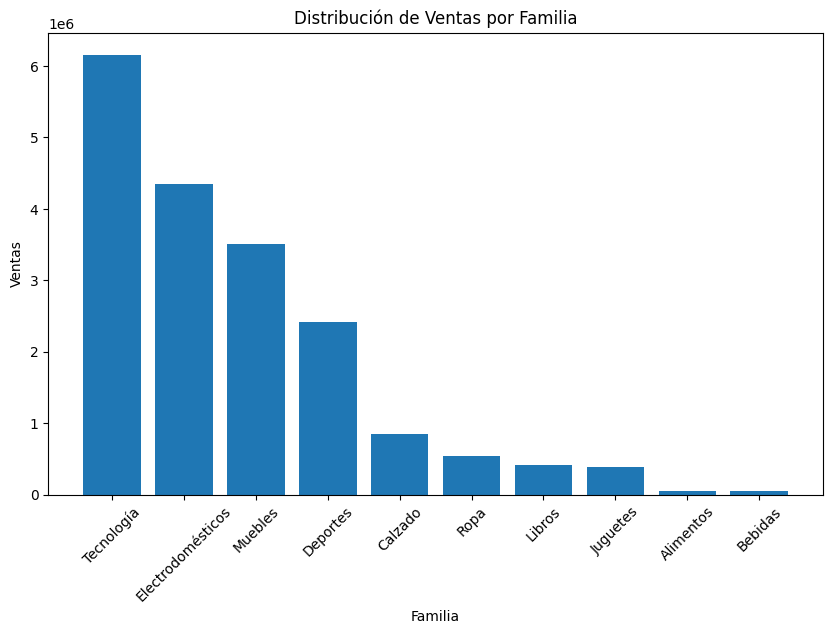

In [9]:
# Gráfico de barras

plt.figure(figsize=(10, 6))
plt.bar(ventas_por_familia.index, ventas_por_familia)
plt.xlabel("Familia")
plt.ylabel("Ventas")
plt.title("Distribución de Ventas por Familia")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Revisión del tipo de datos de cada variable:

data_frame.dtypes

No. factura         int64
Fecha factura      object
Nombre producto    object
Familia            object
Cantidad            int64
Subtotal           object
Vendedor           object
dtype: object

In [11]:
# Conversión del campo "Fecha factura" en un dato tipo date:

data_frame["Fecha factura"] = pd.to_datetime(data_frame["Fecha factura"])

ventas_por_fecha = data_frame.groupby(data_frame["Fecha factura"].dt.to_period("M"))["Subtotal"].sum()
ventas_por_fecha

Fecha factura
2024-01    3828859.2500
2024-02    3510222.6100
2024-03    3867674.2150
2024-04    3822119.4350
2024-05    3684861.6950
Freq: M, Name: Subtotal, dtype: object

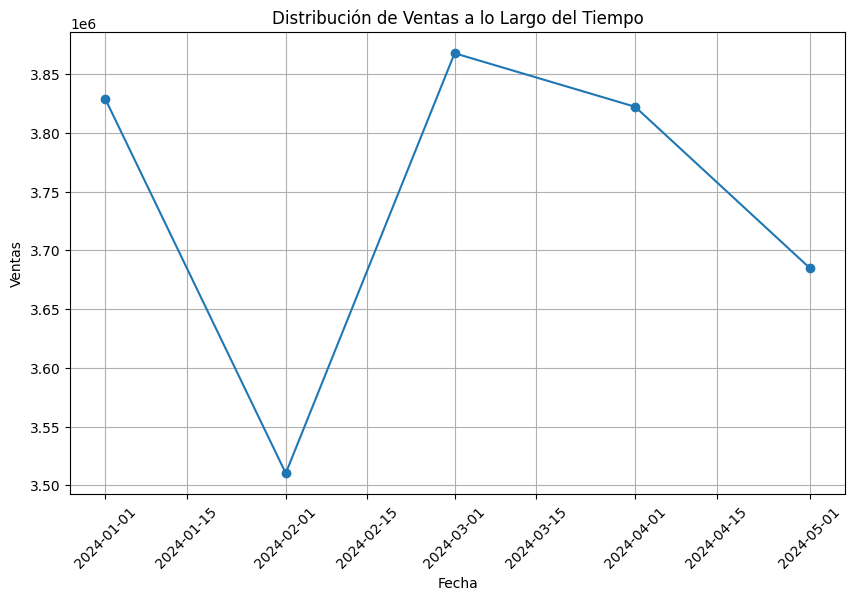

In [12]:
# Gráfico lineal

plt.figure(figsize=(10, 6))
plt.plot(ventas_por_fecha.index.to_timestamp(), ventas_por_fecha, marker="o")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title("Distribución de Ventas a lo Largo del Tiempo")
plt.xticks(rotation=45)
plt.grid()
plt.show()

5. Carga de los datos a origen (archivo Excel)

In [13]:
data_frame.to_excel("mega_store_excel.xlsx", index=False)